In [ ]:
!pip install datasets timm tqdm torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision import models, transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm
import os
from PIL import Image
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_dataset_path = "/content/drive/MyDrive/deepfake/train"
val_dataset_path = "/content/drive/MyDrive/deepfake/val"
test_dataset_path = "/content/drive/MyDrive/deepfake/test"

In [ ]:
class DeepfakeDataset(Dataset):
   def __init__(self, root_dir, transform=None):
       self.root_dir = root_dir
       self.transform = transform
       self.images = []
       self.labels = []

       # Load real images
       real_dir = os.path.join(root_dir, 'real')
       for img_name in os.listdir(real_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(real_dir, img_name))
               self.labels.append(0)

       # Load fake images
       fake_dir = os.path.join(root_dir, 'fake')
       for img_name in os.listdir(fake_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(fake_dir, img_name))
               self.labels.append(1)

   def __len__(self):
       return len(self.images)

   def __getitem__(self, idx):
       img_path = self.images[idx]
       image = Image.open(img_path).convert('RGB')
       label = self.labels[idx]

       if self.transform:
           image = self.transform(image)
       return image, label

def train_model():
   BATCH_SIZE = 16
   EPOCHS = 10
   LEARNING_RATE = 0.001

   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   print(f"Using device: {device}")

   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Resize((299, 299), antialias=True),
       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
   ])

   train_dataset = DeepfakeDataset(root_dir=train_dataset_path, transform=transform)
   val_dataset = DeepfakeDataset(root_dir=val_dataset_path, transform=transform)
   test_dataset = DeepfakeDataset(root_dir=test_dataset_path, transform=transform)

   train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
   val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
   test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

   model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
   num_ftrs = model.fc.in_features
   model.fc = nn.Linear(num_ftrs, 2)
   model = model.to(device)

   criterion = nn.CrossEntropyLoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

   best_val_acc = 0.0
   train_losses, val_losses = [], []
   train_accs, val_accs = [], []

   for epoch in range(EPOCHS):
       print(f"\nEpoch {epoch+1}/{EPOCHS}")

       # Training
       model.train()
       train_loss = 0
       train_correct = 0
       train_total = 0

       for images, labels in tqdm(train_loader, desc="Training"):
           images, labels = images.to(device), labels.to(device)

           optimizer.zero_grad()
           outputs = model(images)
           # Handle auxiliary outputs for inception_v3
           if isinstance(outputs, tuple):
               outputs = outputs[0]
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           train_loss += loss.item()
           _, predicted = torch.max(outputs.data, 1)
           train_total += labels.size(0)
           train_correct += (predicted == labels).sum().item()

       epoch_train_loss = train_loss/len(train_loader)
       epoch_train_acc = 100 * train_correct / train_total
       train_losses.append(epoch_train_loss)
       train_accs.append(epoch_train_acc)

       print(f'Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%')

       # Validation
       model.eval()
       val_loss = 0
       val_correct = 0
       val_total = 0

       with torch.no_grad():
           for images, labels in tqdm(val_loader, desc="Validation"):
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               loss = criterion(outputs, labels)
               val_loss += loss.item()

               _, predicted = torch.max(outputs.data, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()

       epoch_val_loss = val_loss/len(val_loader)
       epoch_val_acc = 100 * val_correct / val_total
       val_losses.append(epoch_val_loss)
       val_accs.append(epoch_val_acc)

       print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%')
       scheduler.step(epoch_val_loss)

       # Plot metrics
       plt.figure(figsize=(12, 4))
       plt.subplot(1, 2, 1)
       plt.plot(train_losses, label='Training Loss')
       plt.plot(val_losses, label='Validation Loss')
       plt.title('Losses over epochs')
       plt.xlabel('Epoch')
       plt.ylabel('Loss')
       plt.legend()

       plt.subplot(1, 2, 2)
       plt.plot(train_accs, label='Training Accuracy')
       plt.plot(val_accs, label='Validation Accuracy')
       plt.title('Accuracies over epochs')
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy (%)')
       plt.legend()

       plt.tight_layout()
       plt.savefig(f'training_metrics_epoch_{epoch}.png')
       plt.close()

       if epoch_val_acc > best_val_acc:
           best_val_acc = epoch_val_acc
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'val_acc': epoch_val_acc,
           }, 'inception_v3_best_model.pth')
           print(f'Saved new best model with validation accuracy: {epoch_val_acc:.2f}%')


if __name__ == '__main__':
   train_model()

Using device: cuda


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 149MB/s] 



Epoch 1/10


Training: 100%|██████████| 25/25 [01:55<00:00,  4.61s/it]


Training Loss: 0.1680, Accuracy: 91.50%


Validation: 100%|██████████| 7/7 [00:53<00:00,  7.66s/it]


Validation Loss: 1.3209, Accuracy: 59.00%
Saved new best model with validation accuracy: 59.00%

Epoch 2/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Training Loss: 0.0265, Accuracy: 99.50%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Validation Loss: 5.7192, Accuracy: 3.00%

Epoch 3/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Training Loss: 0.0017, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Validation Loss: 7.1752, Accuracy: 0.00%

Epoch 4/10


Training: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Training Loss: 0.0814, Accuracy: 97.50%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Validation Loss: 3.5170, Accuracy: 50.00%

Epoch 5/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Training Loss: 0.0044, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Loss: 3.3710, Accuracy: 50.00%

Epoch 6/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Training Loss: 0.0131, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Validation Loss: 4.5432, Accuracy: 49.00%

Epoch 7/10


Training: 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Training Loss: 0.0687, Accuracy: 99.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Validation Loss: 1.3182, Accuracy: 46.00%

Epoch 8/10


Training: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Training Loss: 0.0242, Accuracy: 99.50%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Validation Loss: 4.6905, Accuracy: 50.00%

Epoch 9/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Training Loss: 0.0243, Accuracy: 99.25%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Validation Loss: 7.9062, Accuracy: 45.00%

Epoch 10/10


Training: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Training Loss: 0.0134, Accuracy: 99.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Validation Loss: 9.2104, Accuracy: 50.00%


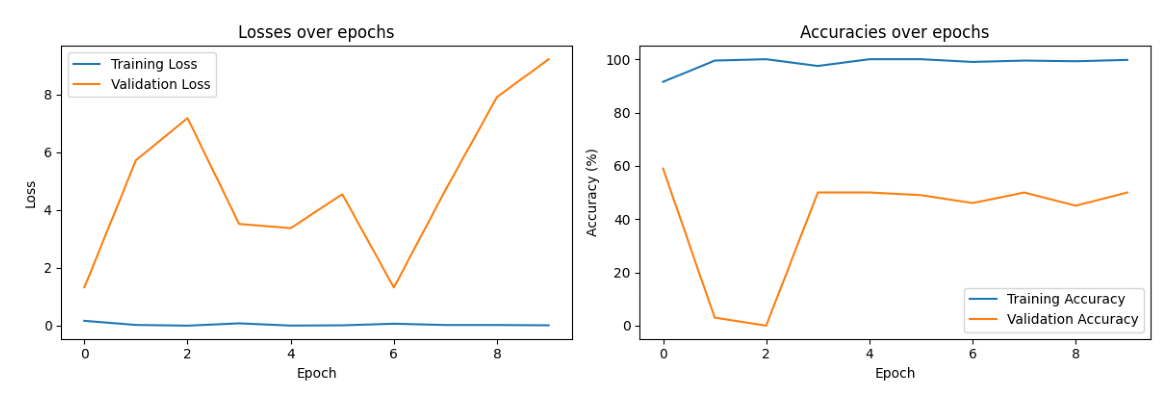

In [ ]:
# Load and display the final epoch's metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('training_metrics_epoch_9.png')  # Assuming 10 epochs (0-9)
plt.figure(figsize=(15,5))
plt.imshow(img)
plt.axis('off')
plt.show()

# Sample Prediction

In [ ]:
def predict_image(image_path, model_path):
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Resize((299, 299), antialias=True),
       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
   ])

   model = models.inception_v3()
   model.fc = nn.Linear(model.fc.in_features, 2)
   model.load_state_dict(torch.load(model_path)['model_state_dict'])
   model.to(device)
   model.eval()

   image = Image.open(image_path).convert('RGB')
   image = transform(image).unsqueeze(0).to(device)

   with torch.no_grad():
       output = model(image)
       _, predicted = torch.max(output.data, 1)
       prob = torch.softmax(output, 1)

   result = 'Fake' if predicted.item() == 1 else 'Real'
   confidence = prob[0][predicted.item()].item() * 100

   return result, confidence

# For single image prediction
result, confidence = predict_image('/content/drive/MyDrive/deepfake/test/real/311.png', 'inception_v3_best_model.pth')
print(f'Prediction: {result} (Confidence: {confidence:.2f}%)')

<ipython-input-8-36b2875209c6>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


Prediction: Fake (Confidence: 94.43%)


# Confusion Matrix

/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
<ipython-input-10-43ea4215c636>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the use

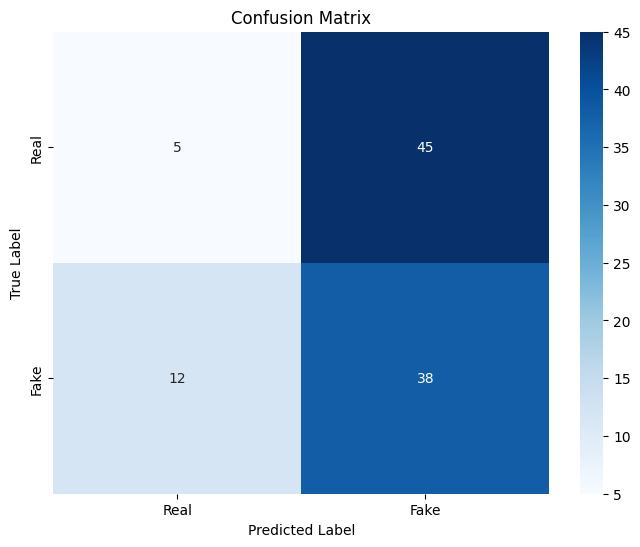


Classification Report:
              precision    recall  f1-score   support

        Real       0.29      0.10      0.15        50
        Fake       0.46      0.76      0.57        50

    accuracy                           0.43       100
   macro avg       0.38      0.43      0.36       100
weighted avg       0.38      0.43      0.36       100



In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.images = []
        self.labels = []

        real_dir = os.path.join(test_dir, 'real')
        for img_name in os.listdir(real_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(real_dir, img_name))
                self.labels.append(0)

        fake_dir = os.path.join(test_dir, 'fake')
        for img_name in os.listdir(fake_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(fake_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

def evaluate_model():
   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Resize((299, 299), antialias=True),
       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
   ])

   test_dataset = DeepfakeDataset(test_dataset_path, transform=transform)
   test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = models.inception_v3()
   model.fc = nn.Linear(model.fc.in_features, 2)
   model.load_state_dict(torch.load('inception_v3_best_model.pth')['model_state_dict'])
   model = model.to(device)
   model.eval()

   all_preds = []
   all_labels = []

   with torch.no_grad():
       for images, labels in tqdm(test_loader, desc="Evaluating"):
           images = images.to(device)
           outputs = model(images)
           _, predicted = torch.max(outputs.data, 1)
           all_preds.extend(predicted.cpu().numpy())
           all_labels.extend(labels.numpy())

   cm = confusion_matrix(all_labels, all_preds)
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Real', 'Fake'],
               yticklabels=['Real', 'Fake'])
   plt.title('Confusion Matrix')
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   plt.show()

   print('\nClassification Report:')
   print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

if __name__ == '__main__':
   # For evaluation
   evaluate_model()
